In [1]:
# Install Category encoders
try:
    import category_encoders
except ImportError:
    !pip install category_encoders

# Install LightGBM
try:
    import lightgbm
except ImportError:
    !pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 182.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 70.4 MB/s eta 0:00:00


In [2]:
# Install required packages
try:
    import optuna
except ImportError:
    !pip install optuna

import optuna
from optuna.samplers import TPESampler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 140.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.6/607.6 kB 59.4 MB/s eta 0:00:00


In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import gc
import os
import json
from datetime import datetime

# LightGBM
import lightgbm as lgb

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Scipy
from scipy.stats import randint, uniform, loguniform

# Category encoders
from category_encoders import TargetEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab
from google.colab import drive

print("All imports successful!")


All imports successful!


In [4]:
# Mount Drive
drive.mount('/content/drive')

# Configuration
CONFIG = {
    'data_path': "/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Saved Data/final_df_v2.parquet",
    'output_dir': "/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/",
    'sample_fraction': 0.10,  # For hyperparameter tuning
    'validation_days': 28,
    'random_state': 42
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("Configuration loaded!")


Mounted at /content/drive
Configuration loaded!


In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df


In [6]:
# Load data
print("Loading data...")
df = pd.read_parquet(CONFIG['data_path'])
df = reduce_mem_usage(df)
gc.collect()

print(f"Shape: {df.shape}, Memory: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

# Define features
target = 'sales_count'
cols_to_drop = ['date', 'wm_yr_wk']
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
all_features = [col for col in df.columns if col != target and col not in cols_to_drop]

print(f"Features: {len(all_features)} ({len(categorical_features)} categorical)")

# Time-based split
df = df.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)
split_date = df['date'].unique()[-CONFIG['validation_days']]

train_df = df[df['date'] < split_date].copy()
val_df = df[df['date'] >= split_date].copy()

print(f"Train: {len(train_df):,} rows | Val: {len(val_df):,} rows")

del df, split_date
gc.collect()


Loading data...
Memory usage decreased to 9820.56 Mb (0.0% reduction)
Shape: (59181090, 55), Memory: 9.59 GB
Features: 52 (9 categorical)
Train: 58,327,370 rows | Val: 853,720 rows


0

In [7]:
# Sample time series for tuning (Stratified by Department)
unique_series = train_df[['item_id', 'store_id', 'dept_id']].drop_duplicates()

# Calculate fraction for stratified sampling
n_series = int(len(unique_series) * CONFIG['sample_fraction'])

# Perform stratified sampling based on 'dept_id'
sampled_series = unique_series.groupby('dept_id', group_keys=False).apply(
    lambda x: x.sample(frac=CONFIG['sample_fraction'], random_state=CONFIG['random_state'])
)

train_sample = pd.merge(train_df, sampled_series, on=['item_id', 'store_id', 'dept_id'], how='inner')

print(f"Sampled {len(sampled_series):,} series (~{CONFIG['sample_fraction']*100:.0f}% of {len(unique_series):,})")
print(f"Sample data: {len(train_sample):,} rows ({len(train_sample)/len(train_df)*100:.1f}% of training data)")

del unique_series, sampled_series
gc.collect()


/tmp/ipython-input-3950907823.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_series = unique_series.groupby('dept_id', group_keys=False).apply(
/tmp/ipython-input-3950907823.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_series = unique_series.groupby('dept_id', group_keys=False).apply(


Sampled 3,049 series (~10% of 30,490)
Sample data: 5,832,737 rows (10.0% of training data)


0

In [8]:
# Fit encoder on training sample
print("Encoding categorical features...")
encoder = TargetEncoder(cols=categorical_features, smoothing=1.0)

X_train_sample = encoder.fit_transform(train_sample[all_features], train_sample[target])
y_train_sample = train_sample[target].values

print(f"Encoded shape: {X_train_sample.shape}")

del train_sample
gc.collect()


Encoding categorical features...
Encoded shape: (5832737, 52)


0

In [9]:
# Define objectives to test
objectives_to_test = [
    'tweedie',
]

# Base parameters (will be updated per objective)
def get_base_params(objective):
    params = {
        'device': 'cpu',
        'objective': objective,
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'seed': CONFIG['random_state']
    }
    if objective == 'tweedie':
        params['tweedie_variance_power'] = 1.5
    return params

print(f"Will test {len(objectives_to_test)} different objective(s): {objectives_to_test}")


Will test 1 different objective(s): ['tweedie']


In [10]:
def optuna_lgb_objective(trial, X, y, base_params, n_splits=3):
    """Optuna objective function for LightGBM"""

    # Optuna suggests parameters
    params = base_params.copy()
    params['n_estimators'] = trial.suggest_int('n_estimators', 200, 800)
    params['num_leaves'] = trial.suggest_int('num_leaves', 31, 127)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    params['feature_fraction'] = trial.suggest_float('feature_fraction', 0.6, 1.0)
    params['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.6, 1.0)
    params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 7)
    params['min_child_samples'] = trial.suggest_int('min_child_samples', 5, 100)
    params['lambda_l1'] = trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True)
    params['lambda_l2'] = trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # Train model
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )

        # Evaluate
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)


In [11]:
print("="*80)
print("OPTUNA HYPERPARAMETER OPTIMIZATION - MULTIPLE OBJECTIVES (GPU)")
print("="*80)

all_results = {}
best_overall_score = float('inf')
best_overall_params = None
best_overall_objective = None

for objective in objectives_to_test:
    print(f"\n{'='*80}")
    print(f"TESTING OBJECTIVE: {objective.upper()}")
    print(f"{'='*80}")

    base_params = get_base_params(objective)

    # Create Optuna study
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=CONFIG['random_state'])
    )

    # Optimize
    study.optimize(
        lambda trial: optuna_lgb_objective(trial, X_train_sample, y_train_sample, base_params),
        n_trials=20,
        show_progress_bar=True
    )

    # Store results
    best_params = study.best_params.copy()
    best_params.update(base_params)
    best_score = study.best_value

    all_results[objective] = {
        'best_params': best_params,
        'best_score': best_score
    }

    print(f"\nBest {objective} RMSE: {best_score:.4f}")

    # Track overall best
    if best_score < best_overall_score:
        best_overall_score = best_score
        best_overall_params = best_params
        best_overall_objective = objective

del X_train_sample, y_train_sample
gc.collect()


[I 2025-12-04 13:52:05,384] A new study created in memory with name: no-name-bf47a2a3-88aa-4ae5-b8c6-634cbbbcbd04


OPTUNA HYPERPARAMETER OPTIMIZATION - MULTIPLE OBJECTIVES (GPU)

TESTING OBJECTIVE: TWEEDIE


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-04 13:52:34,509] Trial 0 finished with value: 2.0524938230515724 and parameters: {'n_estimators': 425, 'num_leaves': 123, 'learning_rate': 0.1205712628744377, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598}. Best is trial 0 with value: 2.0524938230515724.
[I 2025-12-04 13:52:51,502] Trial 1 finished with value: 2.054852975801321 and parameters: {'n_estimators': 625, 'num_leaves': 32, 'learning_rate': 0.2708160864249968, 'feature_fraction': 0.9329770563201687, 'bagging_fraction': 0.6849356442713105, 'bagging_freq': 2, 'min_child_samples': 22, 'lambda_l1': 5.472429642032198e-06, 'lambda_l2': 0.00052821153945323}. Best is trial 0 with value: 2.0524938230515724.
[I 2025-12-04 13:53:31,612] Trial 2 finished with value: 2.0515615092766146 and parameters: {'n_estimators': 459, 'num_leaves': 59, 'learning_rate': 0.08012737503998542, 'feature

130

In [12]:
print("="*80)
print("BEST PARAMETERS")
print("="*80)

print(f"\nBest objective: {best_overall_objective}")
print(f"Best CV RMSE: {best_overall_score:.4f}")
print("\nBest parameters:")
for k, v in sorted(best_overall_params.items()):
    print(f"  {k}: {v}")

# Save best parameters
with open(os.path.join(CONFIG['output_dir'], 'best_params.json'), 'w') as f:
    json.dump(best_overall_params, f, indent=4)

# Save all results for comparison
with open(os.path.join(CONFIG['output_dir'], 'all_objectives_results.json'), 'w') as f:
    json.dump(all_results, f, indent=4)

print(f"\nResults saved to {CONFIG['output_dir']}")


BEST PARAMETERS

Best objective: tweedie
Best CV RMSE: 2.0458

Best parameters:
  bagging_fraction: 0.8278877235479689
  bagging_freq: 7
  boosting_type: gbdt
  device: cpu
  feature_fraction: 0.8940230233886435
  lambda_l1: 0.0014441715954420077
  lambda_l2: 9.604469751203897
  learning_rate: 0.0335729817675125
  metric: rmse
  min_child_samples: 71
  n_estimators: 783
  num_leaves: 100
  objective: tweedie
  seed: 42
  tweedie_variance_power: 1.5
  verbose: -1

Results saved to /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/


In [13]:
print("="*80)
print("TRAINING ON FULL DATA")
print("="*80)

# Load saved best parameters
params_path = os.path.join(CONFIG['output_dir'], 'best_params.json')
print(f"Loading parameters from: {params_path}")

with open(params_path, 'r') as f:
    best_params = json.load(f)

print("Loaded parameters:")
for k, v in sorted(best_params.items()):
    print(f"  {k}: {v}")

# Encode full training data
print("\nEncoding full training data...")
encoder_full = TargetEncoder(
    cols=categorical_features,
    smoothing=1.0
)

X_train_full = encoder_full.fit_transform(train_df[all_features], train_df[target])
y_train_full = train_df[target].values

# Encode validation data
print("Encoding validation data...")
X_val = encoder_full.transform(val_df[all_features])
y_val = val_df[target].values

print(f"Training shape: {X_train_full.shape}")
print(f"Validation shape: {X_val.shape}")

# Train final model
print("\nTraining final LightGBM model...")
start_time = datetime.now()

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50, verbose=True)]
)

duration = (datetime.now() - start_time).total_seconds()
print(f"\nTraining completed in {duration/60:.1f} minutes!")

del X_train_full, y_train_full
gc.collect()


TRAINING ON FULL DATA
Loading parameters from: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/best_params.json
Loaded parameters:
  bagging_fraction: 0.8278877235479689
  bagging_freq: 7
  boosting_type: gbdt
  device: cpu
  feature_fraction: 0.8940230233886435
  lambda_l1: 0.0014441715954420077
  lambda_l2: 9.604469751203897
  learning_rate: 0.0335729817675125
  metric: rmse
  min_child_samples: 71
  n_estimators: 783
  num_leaves: 100
  objective: tweedie
  seed: 42
  tweedie_variance_power: 1.5
  verbose: -1

Encoding full training data...
Encoding validation data...
Training shape: (58327370, 52)
Validation shape: (853720, 52)

Training final LightGBM model...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[783]	valid_0's rmse: 1.93898

Training completed in 6.8 minutes!


418

In [14]:
print("="*80)
print("VALIDATION RESULTS")
print("="*80)

# Predictions
val_pred = final_model.predict(X_val)

# Metrics
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae = mean_absolute_error(y_val, val_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# Baseline comparison
naive_pred = val_df.groupby(['item_id', 'store_id'])[target].transform('mean').fillna(0)
baseline_rmse = np.sqrt(mean_squared_error(y_val, naive_pred))

print(f"\nBaseline RMSE: {baseline_rmse:.4f}")
print(f"Improvement: {(1 - rmse/baseline_rmse)*100:.1f}%")

del naive_pred
gc.collect()


VALIDATION RESULTS
RMSE: 1.9390
MAE:  0.9853

Baseline RMSE: 1.9818
Improvement: 2.2%


/tmp/ipython-input-3056101119.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  naive_pred = val_df.groupby(['item_id', 'store_id'])[target].transform('mean').fillna(0)


4

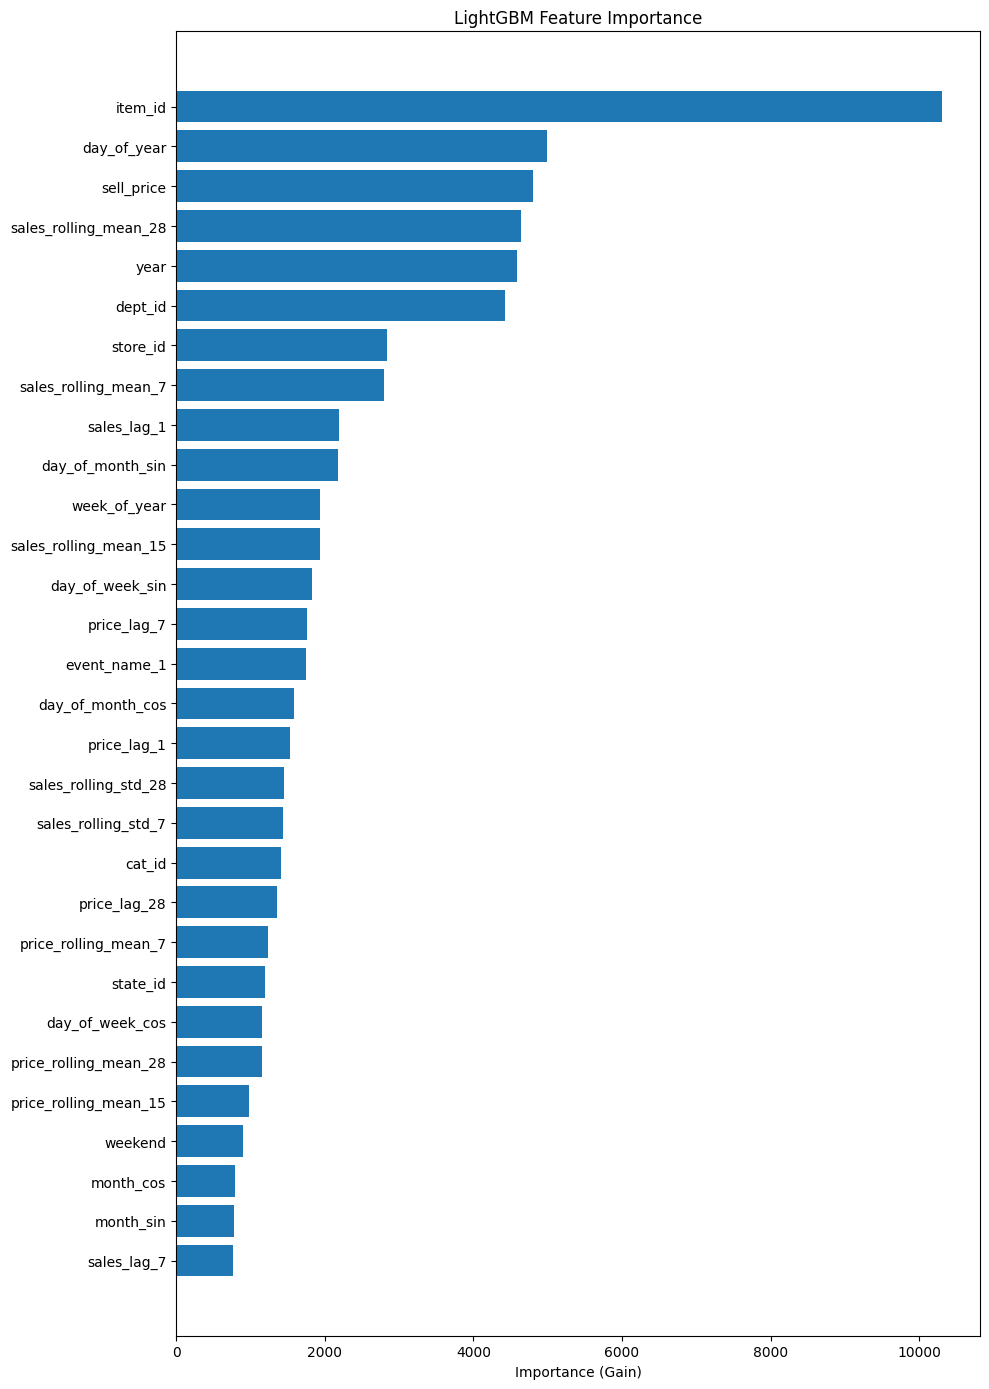

In [15]:
# Get feature importance
importance = final_model.feature_importances_
feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importance
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 14))
plt.barh(feat_imp['feature'].head(30), feat_imp['importance'].head(30))
plt.xlabel('Importance (Gain)')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'feature_importance_lgbm.png'), dpi=300)
plt.show()

# Save
feat_imp.to_csv(os.path.join(CONFIG['output_dir'], 'feature_importance_lgbm.csv'), index=False)


/tmp/ipython-input-1730789504.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_cat = val_df_analysis.groupby('cat_id').agg({


Error by Category:
           residual  abs_error  sales_count
cat_id                                     
FOODS         0.045      1.256        2.069
HOBBIES       0.018      0.740        0.732
HOUSEHOLD     0.021      0.746        0.967


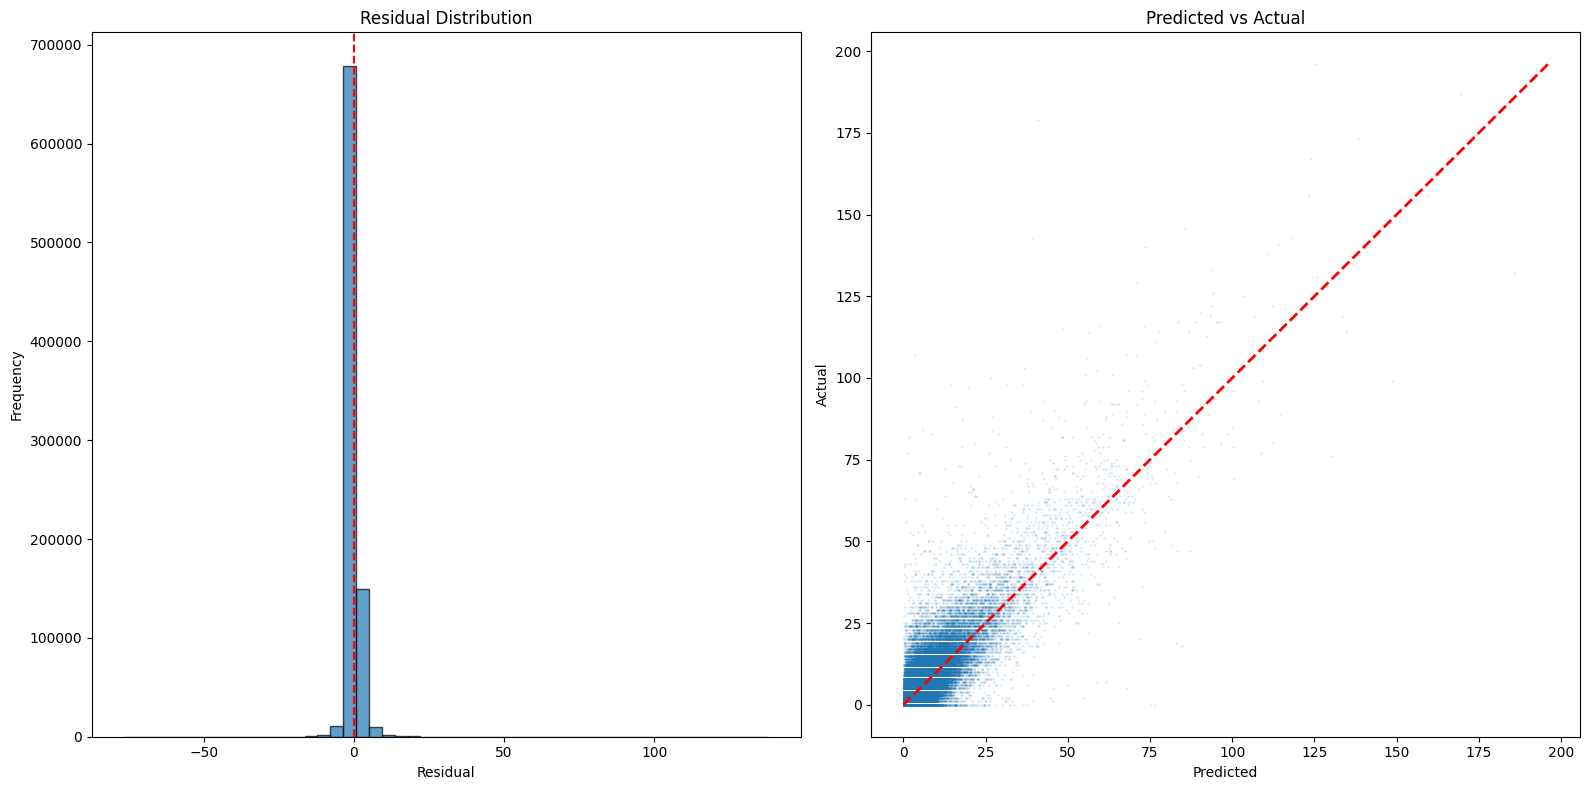

6717

In [16]:
# Residual analysis
residuals = y_val - val_pred
val_df_analysis = val_df.copy()
val_df_analysis['prediction'] = val_pred
val_df_analysis['residual'] = residuals
val_df_analysis['abs_error'] = np.abs(residuals)

# Error by category
error_by_cat = val_df_analysis.groupby('cat_id').agg({
    'residual': 'mean',
    'abs_error': 'mean',
    target: 'mean'
}).round(3)

print("Error by Category:")
print(error_by_cat)

# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residual Distribution')
axes[0].axvline(0, color='red', linestyle='--')

axes[1].scatter(val_pred, y_val, alpha=0.1, s=1)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Predicted vs Actual')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'error_analysis_lgbm.png'), dpi=300)
plt.show()

del val_df_analysis
gc.collect()


In [17]:
# Save model
model_path = os.path.join(CONFIG['output_dir'], 'lgbm_model_final.txt')
final_model.booster_.save_model(model_path)

# Save encoder
import pickle
encoder_path = os.path.join(CONFIG['output_dir'], 'encoder_final.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder_full, f)

# Save results
results = {
    'val_rmse': float(rmse),
    'val_mae': float(mae),
    'baseline_rmse': float(baseline_rmse),
    'improvement_pct': float((1 - rmse/baseline_rmse)*100),
    'best_params': best_params,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(CONFIG['output_dir'], 'results_final.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"Model saved: {model_path}")
print(f"Encoder saved: {encoder_path}")
print(f"Results saved: {os.path.join(CONFIG['output_dir'], 'results_final.json')}")


Model saved: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/lgbm_model_final.txt
Encoder saved: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/encoder_final.pkl
Results saved: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/results_final.json


In [18]:
print("="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"""
Device: A100 GPU
Validation RMSE: {rmse:.4f}
Improvement: {(1 - rmse/baseline_rmse)*100:.1f}%
All files saved to: {CONFIG['output_dir']}
""")


TRAINING COMPLETE!

Device: A100 GPU
Validation RMSE: 1.9390
Improvement: 2.2%
All files saved to: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/LightGBM_Results/

